In [241]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.metrics import mean_squared_error

In [2]:
file = pd.read_csv("sap_storing_data_hu_project.csv", low_memory=False)

In [3]:
pd.set_option("display.max_columns", None)

Zodat de dataset niet steeds opnieuw hoeft worden ingeladen, maken we een copy.

In [90]:
df = file.copy()
df.head()

,Unnamed: 0,#stm_sap_meldnr,stm_mon_nr,stm_vl_post,stm_sap_meld_ddt,stm_sap_mon_meld_ddt,stm_sap_meldtekst_lang,stm_mon_begin_ddt,stm_sap_meldtekst,stm_mon_toelichting_trdl,stm_oh_pg_mld,stm_geo_mld,stm_geo_mld_uit_functiepl,stm_equipm_nr_mld,stm_equipm_soort_mld,stm_equipm_omschr_mld,stm_km_van_mld,stm_km_tot_mld,stm_prioriteit,stm_scenario_mon,stm_status_melding_sap,stm_mon_nr_status_omschr,stm_mon_nr__statuscode,stm_mon_nr_status_wijzdd,stm_aanngeb_ddt,stm_aanntpl_ddt,stm_oh_pg_gst,stm_geo_gst,stm_geo_gst_uit_functiepl,stm_equipm_nr_gst,stm_equipm_soort_gst,stm_equipm_omschr_gst,stm_objectdl_code_gst,stm_objectdl_groep_gst,stm_km_van_gst,stm_km_tot_gst,stm_progfh_in_ddt,stm_progfh_in_invoer_ddt,stm_progfh_gw_ddt,stm_progfh_gw_lwd_ddt,stm_progfh_hz,stm_oorz_groep,stm_oorz_code,stm_oorz_tkst,stm_veroorz_groep,stm_veroorz_code,stm_veroorz_tekst_kort,stm_effect,stm_afspr_aanvangddt,stm_fh_ddt,stm_fh_status,stm_sap_storeind_ddt,stm_mon_eind_ddt,stm_mon_vhdsincident,stm_tao_indicator,stm_tao_indicator_vorige,stm_tao_soort_mutatie,stm_tao_telling_mutatie,stm_tao_beinvloedbaar_indicator,stm_evb,stm_dir_betrok_tr,stm_aangelegd_dd,stm_aangelegd_tijd,stm_sap_melddatum,stm_sap_meldtijd,stm_mon_begindatum,stm_mon_begintijd,stm_contractgeb_mld,stm_functiepl_mld,stm_techn_mld,stm_contractgeb_gst,stm_functiepl_gst,stm_techn_gst,stm_aanngeb_dd,stm_aanngeb_tijd,stm_aanntpl_dd,stm_aanntpl_tijd,stm_arbeid,stm_progfh_in_datum,stm_progfh_in_tijd,stm_progfh_in_invoer_dat,stm_progfh_in_invoer_tijd,stm_progfh_in_duur,stm_progfh_gw_datum,stm_progfh_gw_tijd,stm_progfh_gw_lwd_datum,stm_progfh_gw_lwd_tijd,stm_progfh_gw_duur,stm_progfh_gw_teller,stm_afspr_aanvangdd,stm_afspr_aanvangtijd,stm_fh_dd,stm_fh_tijd,stm_fh_duur,stm_reactie_duur,stm_sap_storeinddatum,stm_sap_storeindtijd,stm_mon_eind_datum,stm_mon_eind_tijd,stm_controle_dd,stm_akkoord_mon_toewijz,stm_status_sapnaarmon,stm_fact_jn,stm_akkoord_melding_jn,stm_afsluit_ddt,stm_afsluit_dd,stm_afsluit_tijd,stm_rec_toegev_ddt,stm_hinderwaarde,stm_actie,stm_standplaats,stm_status_gebr,stm_wbi_nummer,stm_projnr,stm_oorz_tekst_kort,stm_historie_toelichting,stm_schade_verhaalb_jn,stm_schadenr,stm_schade_status_ga,stm_schade_statusdatum,stm_relatiervo_vorig,stm_relatiervo_volgend,stm_relatiervo,stm_pplg_van,stm_pplg_naar,stm_dstrglp_van,stm_dstrglp_naar,stm_afspr_func_hersteldd,stm_afspr_func_hersteltijd,stm_sorteerveld,stm_rapportage_maand,stm_rapportage_jaar,stm_x_bron_publ_dt,stm_x_bron_bestandsnaam,stm_x_bron_arch_dt,stm_x_actueel_ind,stm_x_run_id,stm_x_bk,stm_x_start_sessie_dt,stm_x_vervallen_ind
0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,0,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,2014,07/05/2014 05:30:12,\\PUHAPS0149\Informatica_Prod\Inbox\Informatic...,31/12/9999 00:00:00,1,34415,3617016,07/05/2014 05:44:24,0
1,1,50053211,0.0,NaN,02/01/2006 09:00:00,02/01/2006 09:00:00,Logboeknr Geeltje : 49 Tijd: 0900 VL-Po...,NaN,Logboeknr Geeltje : 49 Tijd: 0900,NaN,NaN,624.0,624.0,NaN,NaN,NaN,0.0,0.0,9.0,NaN,MAFS MAFD,NaN,NaN,00/00/0000,02/01/2006 09:00:00,NaN,81S,624.0,624.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,Z,ONR-RIB,133.0,Papieren ontbreken,ONREGRIB,B,Volker,NaN,NaN,02/01/2006 09:00:00,4.0,02/01/2006 09:00:00,NaN,NaN,N,NaN,NaN,0,B,"0,00",NaN,03/01/2006,04:48:18,02/01/2006,09:00:00,NaN,NaN,NaN,624,NaN,81.0,624,S,02/01/2006,09:00:00,NaN,00:00:00,99999999.0,NaN,00:00:00,NaN,00:00:00,99999999.0,NaN,00:00:00,NaN,NaN,99999999.0,0.0,00/00/0000,00:00:00,02/01/2006,09:00:00,0.0,99999999.0,02/01/2006,09:00:00,NaN,NaN,05/01/2006,J,NaN,N,J,05/01/2009 15:10:09,05/01/2009,15:10:09,02/01/2006 04:

In [91]:
df = df.drop([0,0])

De eerste kolom is leeg, dus deze halen we er alvast uit.

In [92]:
# Meest efficiente manier om het aantal rijen te achterhalen
print("Aantal rijen in de dataset:", len(df.index))

Aantal rijen in de dataset: 898525


### Doel oftewel 'Target'
Ons doel is om te voorspellen wanneer het systeem weer opgestart kan worden. De manier waarop je dit meet, is door te kijken hoe lang de functie hersteltijd heeft geduurd. Hiervoor hebben we de volgende belangrijke datapunten geïdentificeerd:
- Datum en tijdstip van functie herstel
- Duur van functie herstel
- Datum en tijdstip van einde storing

Vooral de duur van de functieherstel is belangrijk, dus hier gaan we naar kijken. Deze staat in de database als "stm_fh_duur", maar gaan we hernoemen voor leesbaarheid.

In [93]:
# Hernoemt de functie herstel duur kolom.
df = df.rename(columns={'stm_fh_duur': 'functie_herstel_duur'})

#### Meetniveau

In [94]:
df[['functie_herstel_duur']].head(10)

,functie_herstel_duur
1,0.0
2,51.0
3,40.0
4,6.0
5,7.0
6,13.0
7,15.0
8,30.0
9,0.0
10,0.0


Nu zien we de waarden die bij de target variabel horen. Deze data is waarschijnlijk uitgedrukt in minuten. Dit is een **aanname** die wij voorlopig doen, tot we dit verifiëren. Dit is een *continue* waarde, hoewel de minuten zijn afgerond.

#### Data Analyse

In [95]:
df.functie_herstel_duur.describe()

count    898488.000000
mean        923.148771
std        6404.546787
min           0.000000
25%          11.000000
50%          84.000000
75%         256.000000
max      528297.000000
Name: functie_herstel_duur, dtype: float64

De bovenste gegevens laten het een en ander zien over de gegevens in de feature variabel. 
- We hebben 898488 datapunten, dus missen we er 37, ofwel 0.004%. Dit is vrijwel niets. We kunnen deze rijen dus uit de dataframe verwijderen zonder dat dit gevolgen zal hebben op de prestatie van het model.
- De gemiddelde hersteltijd is 923 minuten;
- De standaardafwijking ligt op 6404 minuten. Deze waarden kunnen nooit realistisch zijn, wat betekent dat we veel datapunten hebben die de waarden scheeftrekken.
- 25% van de waarden liggen op of onder 11 minuten;
- 50% van de waarden liggen op of onder 84 minuten;
- 75% van de waarden liggen op of onder 256 minuten;
- De maximum ligt op 528297 minuten.

Waarom deze waarden zo hoog liggen gaan we later onderzoeken. Ten eerste is het handig om te zien hoe de data verdeeld is.

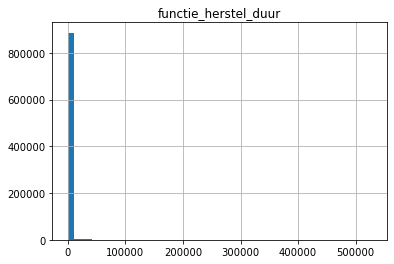

In [96]:
df.hist('functie_herstel_duur', bins = 50)
plt.show()

Zoals op de bovenstaande histogram te zien is, zitten de meeste waarden laag en hebben we uitschieters aan de hoge kant. Als we nog wat verder inzoomen, kunnen we een wat betere representatie krijgen.

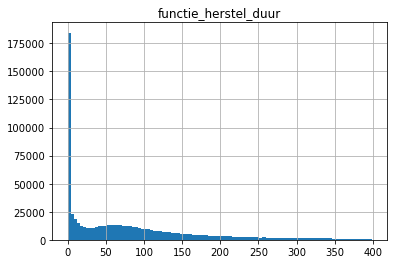

In [97]:
df[df.functie_herstel_duur < 400].hist('functie_herstel_duur', bins=100)
plt.show()

Zoals hier te zien is, duren de meeste hersteltijden 0 minuten. Of dit foutieve data kan zijn zullen we later moeten achterhalen.

#### Outliers analyseren

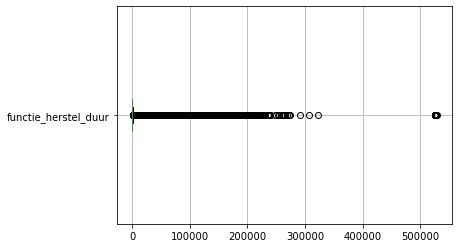

In [98]:
df.boxplot('functie_herstel_duur', vert=False)
plt.show()

Op de boxplot valt duidelijk te zien dat we met erg veel uitschieters te maken hebben aan de hoge kant. Deze gaan we later verwijderen omdat ze geen waarde toevoegen aan het maken van een nuttige voorspelling. Om dit te doen, moeten we gebruik maken van de kwartielen en interkwartielafstand.
We hebben we ook uitschieters aan de onderkant. Echter zijn deze wel van belang. Een storing van 1 minuut is nog steeds een storing waarover we voorspellingen willen doen. Daarom halen we alleen de hoge outliers eruit. Daarnaast heeft de opdrachtgever aangegeven dat vooral de kortere storingen belangrijk zijn om te voorspellen.

Om de (hoge) outliers eruit te halen maken we gebruik van de volgende vuistregel:
- Q1 = de eerste 25% van de kolom
- Q3 = de eerste 75% van de kolom
- IQR (interkwartale afstand) = Q3 - Q1
- Alles vanaf Q3 + 3 * IQR is een sterke uitschieter
- Alles tussen Q3 + 1.5 * IQR en de laagste sterke uitschieter is een zwakke uitschieter
- Alles vanaf de laagste zwakke uitschieter wordt uit de data gefilterd

In [99]:
q1 = df.functie_herstel_duur.quantile(.25)
q3 = df.functie_herstel_duur.quantile(.75)
iqr = q3 - q1

#Outliers bepalen
out_hi_st = df.functie_herstel_duur[(df.functie_herstel_duur >= q3 + iqr * 3)]
out_hi_wk = df.functie_herstel_duur[((df.functie_herstel_duur >= q3 + iqr * 1.5) & (df.functie_herstel_duur < q3 + iqr * 3))]
print("Er zitten {} ({:.2f}%) outliers aan de hoge kant, waarvan {} zwak en {} sterk.".format(out_hi_st.shape[0] + out_hi_wk.shape[0],
                                                                                          (out_hi_st.shape[0] + out_hi_wk.shape[0])/898525*100,
                                                                                          out_hi_wk.shape[0],
                                                                                          out_hi_st.shape[0]))

Er zitten 144190 (16.05%) outliers aan de hoge kant, waarvan 40357 zwak en 103833 sterk.


We gaan de grootste sterke uitschieter eens bekijken

In [100]:
out_hi_st.sort_values(ascending = False).head(1)

670693    528297.0
Name: functie_herstel_duur, dtype: float64

In [101]:
df[df.functie_herstel_duur == 528297.0]

,Unnamed: 0,#stm_sap_meldnr,stm_mon_nr,stm_vl_post,stm_sap_meld_ddt,stm_sap_mon_meld_ddt,stm_sap_meldtekst_lang,stm_mon_begin_ddt,stm_sap_meldtekst,stm_mon_toelichting_trdl,stm_oh_pg_mld,stm_geo_mld,stm_geo_mld_uit_functiepl,stm_equipm_nr_mld,stm_equipm_soort_mld,stm_equipm_omschr_mld,stm_km_van_mld,stm_km_tot_mld,stm_prioriteit,stm_scenario_mon,stm_status_melding_sap,stm_mon_nr_status_omschr,stm_mon_nr__statuscode,stm_mon_nr_status_wijzdd,stm_aanngeb_ddt,stm_aanntpl_ddt,stm_oh_pg_gst,stm_geo_gst,stm_geo_gst_uit_functiepl,stm_equipm_nr_gst,stm_equipm_soort_gst,stm_equipm_omschr_gst,stm_objectdl_code_gst,stm_objectdl_groep_gst,stm_km_van_gst,stm_km_tot_gst,stm_progfh_in_ddt,stm_progfh_in_invoer_ddt,stm_progfh_gw_ddt,stm_progfh_gw_lwd_ddt,stm_progfh_hz,stm_oorz_groep,stm_oorz_code,stm_oorz_tkst,stm_veroorz_groep,stm_veroorz_code,stm_veroorz_tekst_kort,stm_effect,stm_afspr_aanvangddt,stm_fh_ddt,stm_fh_status,stm_sap_storeind_ddt,stm_mon_eind_ddt,stm_mon_vhdsincident,stm_tao_indicator,stm_tao_indicator_vorige,stm_tao_soort_mutatie,stm_tao_telling_mutatie,stm_tao_beinvloedbaar_indicator,stm_evb,stm_dir_betrok_tr,stm_aangelegd_dd,stm_aangelegd_tijd,stm_sap_melddatum,stm_sap_meldtijd,stm_mon_begindatum,stm_mon_begintijd,stm_contractgeb_mld,stm_functiepl_mld,stm_techn_mld,stm_contractgeb_gst,stm_functiepl_gst,stm_techn_gst,stm_aanngeb_dd,stm_aanngeb_tijd,stm_aanntpl_dd,stm_aanntpl_tijd,stm_arbeid,stm_progfh_in_datum,stm_progfh_in_tijd,stm_progfh_in_invoer_dat,stm_progfh_in_invoer_tijd,stm_progfh_in_duur,stm_progfh_gw_datum,stm_progfh_gw_tijd,stm_progfh_gw_lwd_datum,stm_progfh_gw_lwd_tijd,stm_progfh_gw_duur,stm_progfh_gw_teller,stm_afspr_aanvangdd,stm_afspr_aanvangtijd,stm_fh_dd,stm_fh_tijd,functie_herstel_duur,stm_reactie_duur,stm_sap_storeinddatum,stm_sap_storeindtijd,stm_mon_eind_datum,stm_mon_eind_tijd,stm_controle_dd,stm_akkoord_mon_toewijz,stm_status_sapnaarmon,stm_fact_jn,stm_akkoord_melding_jn,stm_afsluit_ddt,stm_afsluit_dd,stm_afsluit_tijd,stm_rec_toegev_ddt,stm_hinderwaarde,stm_actie,stm_standplaats,stm_status_gebr,stm_wbi_nummer,stm_projnr,stm_oorz_tekst_kort,stm_historie_toelichting,stm_schade_verhaalb_jn,stm_schadenr,stm_schade_status_ga,stm_schade_statusdatum,stm_relatiervo_vorig,stm_relatiervo_volgend,stm_relatiervo,stm_pplg_van,stm_pplg_naar,stm_dstrglp_van,stm_dstrglp_naar,stm_afspr_func_hersteldd,stm_afspr_func_hersteltijd,stm_sorteerveld,stm_rapportage_maand,stm_rapportage_jaar,stm_x_bron_publ_dt,stm_x_bron_bestandsnaam,stm_x_bron_arch_dt,stm_x_actueel_ind,stm_x_run_id,stm_x_bk,stm_x_start_sessie_dt,stm_x_vervallen_ind
670693,678353,80788023,0.0,NaN,29/11/2014 07:48:00,29/11/2014 07:48:00,Whv : Wl 901a ging pas na 5x bedienen om.,NaN,Whv : Wl 901a ging pas na 5x bedienen om,NaN,09B,485,485.0,10265311.0,WISSEL,485 Chv krs 901K (ts 52-58AB),0.0,0.0,5.0,NaN,MAFS,NaN,NaN,00/00/0000,29/11/2014 07:48:00,01/12/2014 04:40:00,09B,485.0,485.0,10265311.0,WISSEL,485 Chv krs 901K (ts 52-58AB),NaN,NaN,0.0,0.0,01/12/2014 05:21:00,01/12/2014 04:21:56,NaN,NaN,Z,ONR-DERD,146.0,485 Chv krs 901K 485 485 Chv krs 901K (ts 52-...,ONREGDER,T,NaN,NaN,NaN,01/12/2015 04:45:00,1.0,01/12/2015 05:00:00,NaN,NaN,N,NaN,NaN,0,NB,"0,00",NaN,29/11/2014,07:48:34,29/11/2014,07:48:00,NaN,NaN,9.0,485-302-1000043136,B,9.0,485-302-1000043136,B,29/11/2014,07:48:00,01/12/2014,04:40:00,525605.0,01/12/2014,05:21:00,01/12/2014,04:21:56,41,NaN,00:00:00,NaN,NaN,99999999,0.0,01/12/2014,08:00:00,01/12/2015,04:45:00,528297.0,2692.0,01/12/2015,05:00:00,NaN,NaN,06/05/2015,NaN,NaN,NaN,J,06/05/2015 14:12:51,06/05/2015,14:12:51,29/11/2014 07:48:34,0.0,NaN,4.0,IN5 H4,NaN,NaN,485 Chv krs 901K 485 485 Chv krs 901K (t,NaN,NaN,0.0,NaN,0,NaN,NaN,80788023,NaN,NaN,NaN,NaN,01/12/2014,16:00:00,901K,4,2015,03/05/2015 06:00:00,\\PUHAPS0149\Informatica_Prod\Inbox\Informatic...,31/12/9999 00:00:00,1,161403,3658194,19/05/2015 07:49:43,0


#### Outliers verwijderen

In [104]:
#Outliers verwijderen
df = df[(df.functie_herstel_duur < (q3 + 1.5 * iqr))]

#### Nulwaarden en NaN's analyseren

In [105]:
print("Er zijn {} nul-waarden, oftewel {:.2f}% van de originele dataset.".format(df[(df.functie_herstel_duur <= 0)].shape[0], df[(df.functie_herstel_duur <= 0)].shape[0] / 898525 * 100))
nuls = df[(df.functie_herstel_duur < 1)]

Er zijn 171713 nul-waarden, oftewel 19.11% van de originele dataset.


In [106]:
print("Er zijn {} NaN's.".format(df.functie_herstel_duur.isnull().sum()))

Er zijn 0 NaN's.


#### Nulwaarden verwijderen

In [107]:
df = df[(df.functie_herstel_duur > 0)]

Een storing van 0 minuten halen we ook weg. We maken hierbij de **aanname** dat een storing van 0 minuten geen impact heeft op de reistijd. Zo een storing hoeft niet opgelost te worden en de trein kan meteen opstarten.

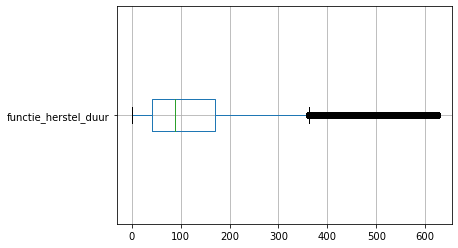

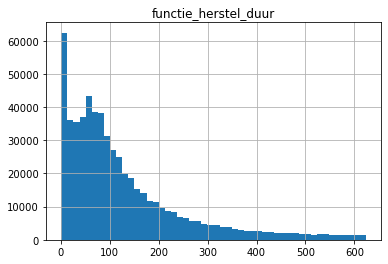

In [120]:
df.boxplot('functie_herstel_duur', vert=False)
plt.show()
df.hist('functie_herstel_duur', bins=50)
plt.show()

In [115]:
df.functie_herstel_duur.describe()

count    582585.000000
mean        128.907461
std         126.529771
min           1.000000
25%          42.000000
50%          89.000000
75%         170.000000
max         623.000000
Name: functie_herstel_duur, dtype: float64

Nu ziet de boxplot er wat logischer uit en is de data beter te gebruiken om voorspellingen mee te doen. Ook de histogram ziet er nu wat beter uit, nu de nullen zijn weggehaald. 

Het gemiddelde ligt nu op 129 minuten, iets meer dan een uur. Maar de standaardafwijking ligt op 126. Dat is omdat we te maken hebben met een rechts-scheve verdeling.

### Baseline Model
Het is belangrijk om een baseline te hebben. Dit is een rudimentaire voorspelling, die we als lat leggen voor onze andere modellen. 
Als we het gemiddelde voorspellen, zullen we er ongetwijfeld steeds ver naast liggen. Echter lijkt dit een goede simpele baseline.

#### Het splitsen van de dataset
We splitsen de data op in een train- en testset.

In [262]:
X = df
y = df.functie_herstel_duur
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

#### Voorspellen

In [274]:
dr_mean = DummyRegressor(strategy = 'mean').fit(X_train, y_train)
dr_median = DummyRegressor(strategy = 'median').fit(X_train, y_train)
dr_modus = DummyRegressor(strategy = 'constant', constant=).fit(X_train, y_train)

y_predict_mean = dr_mean.predict(X_test)
y_predict_median = dr_median.predict(X_test)

print("RMSE bij mean raden: {}".format(mean_squared_error(y_test, y_predict_mean, squared=False)))
print("RMSE bij median raden {}".format(mean_squared_error(y_test, y_predict_median, squared=False)))

RMSE bij mean raden: 126.96571374930343
RMSE bij median raden 133.6005485752467


Als we de gemiddelde steeds voorspellen, zullen we er gemiddeld ongeveer 126 minuten naast zitten.
Als we de mediaan steeds voorspellen, zullen we er gemiddeld ongeveer 133 minuten naast zitten. 
Dat is beide teveel.